#                                            DATA SCIENCE 

##  1. Importing modules

In [1]:
import os 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import matplotlib.mlab as mlab
import warnings
warnings.filterwarnings("ignore")


from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_squared_error as MSE
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, cross_val_predict


# Settings
import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8.5, 5)
plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.mpl.rc("figure", figsize=(8.5,5))


%matplotlib inline

In [3]:
import os

train = pd.read_csv ('train.csv')
test = pd.read_csv ('test.csv')

train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663


## 2. Loading files

##  3. DATA CLEANING & EXPLORATION

### a. Cleaning data

In [4]:
train.shape;

In [5]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### missing values   

In [7]:
#test.isna().sum()
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

###  Outlayers   

In [8]:
train = train[train['passenger_count']>0]
train = train[train['passenger_count']<9]

In [9]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [10]:
trip_duration_mean = np.mean(train['trip_duration'])
trip_duration_std = np.std(train['trip_duration'])
train = train[train['trip_duration']<=trip_duration_mean + 2*trip_duration_std]
train = train[train['trip_duration']>= trip_duration_mean - 2*trip_duration_std]

To have a better representation of trip duration we have to remove or substract trip duraiton whose deviation is twice greater than standard deviation.

### Data preprocessing 

###### extracting dates, by converting them from "object" type to "datetime" type

In [11]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime) # Pickups
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) # Drop-offs

In [12]:
# Delimit pickup_datetime variable 
train['pickup_date'] = train['pickup_datetime'].dt.date # Extract date
train['pickup_time'] = train['pickup_datetime'].dt.time # Extract time

# Delimit dropoff_datetime variables
train['dropoff_date'] = train['dropoff_datetime'].dt.date # Extract date
train['dropoff_time'] = train['dropoff_datetime'].dt.time # Extract time

# Additional pickup features
train['pickup_month'] = train['pickup_datetime'].dt.month # Extract month

train['pickup_hour'] = train['pickup_datetime'].dt.hour # Extract hour
train['pickup_weekday'] = train['pickup_datetime'].dt.dayofweek # Extract day of week

In [13]:
# Drop concatentated timestamp columns
train.drop(['pickup_datetime'], axis = 1, inplace = True)
train.drop(['dropoff_datetime'], axis = 1, inplace = True)

##### exctracting distance variable from longitudes and latitudes 

In [14]:
train['dist_long'] = train['pickup_longitude'] - train['dropoff_longitude']
test['dist_long'] = test['pickup_longitude'] - test['dropoff_longitude']

train['dist_lat'] = train['pickup_latitude'] - train['dropoff_latitude']
test['dist_lat'] = test['pickup_latitude'] - test['dropoff_latitude']

train['dist'] = np.sqrt(np.square(train['dist_long']) + np.square(train['dist_lat']))
test['dist'] = np.sqrt(np.square(test['dist_long']) + np.square(test['dist_lat']))

##### extracting spatial data

In [15]:
train['pickup_longitude'] = np.round(train['pickup_longitude'], 2)
train['pickup_latitude'] = np.round(train['pickup_latitude'], 2)
train['dropoff_longitude'] = np.round(train['dropoff_longitude'], 2)
train['dropoff_latitude'] = np.round(train['dropoff_latitude'], 2)

## **b. Visualization**

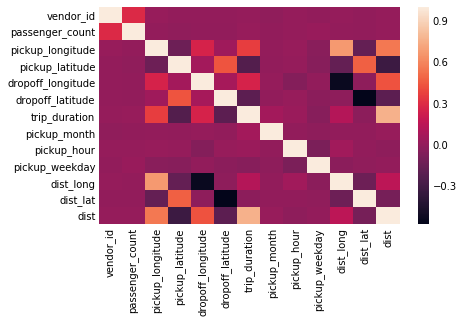

In [16]:
corr = train.corr()
sns.heatmap(corr);

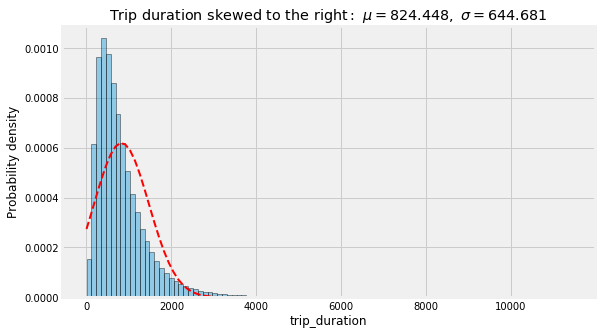

In [17]:
# Mean distribution
mu = train['trip_duration'].mean()

# Std distribution
sigma = train['trip_duration'].std()
num_bins = 100

# Histogram 
fig = plt.figure(figsize=(8.5, 5))
n, bins, patches = plt.hist(train['trip_duration'], num_bins, normed=1,
                           edgecolor = 'black', lw = 1, alpha = .40)
# Normal Distribution
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('trip_duration')
plt.ylabel('Probability density')

# Adding a title
plt.title(r'$\mathrm{Trip\ duration\ skewed \ to \ the \ right:}\ \mu=%.3f,\ \sigma=%.3f$'%(mu,sigma))
plt.grid(True)
#fig.tight_layout()
plt.show();



### Passenger count per trip duration

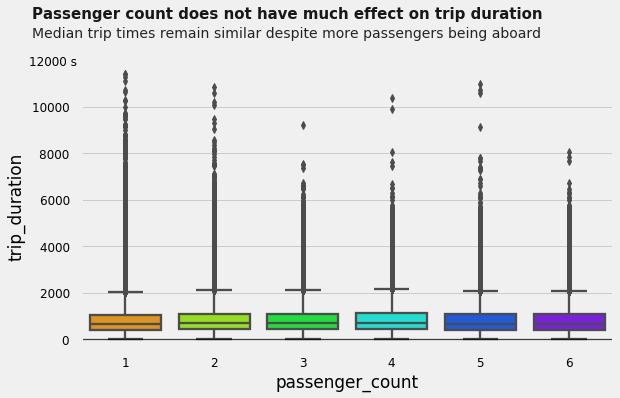

In [18]:

import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
passenger_graph = sns.boxplot(x = 'passenger_count', y = 'trip_duration', data = train, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick size
passenger_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)


# Customize tick labels of the y-axis
passenger_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])


# Bolding horizontal line at y = 0
passenger_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)


# # Adding a title and a subtitle
passenger_graph.text(x =-1.05, y = 13800, s = "Passenger count does not have much effect on trip duration",
               fontsize =15 , weight = 'bold', alpha = .90)
passenger_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times remain similar despite more passengers being aboard',
              fontsize = 14, alpha = .85)
plt.show()



### Trip duration in a week

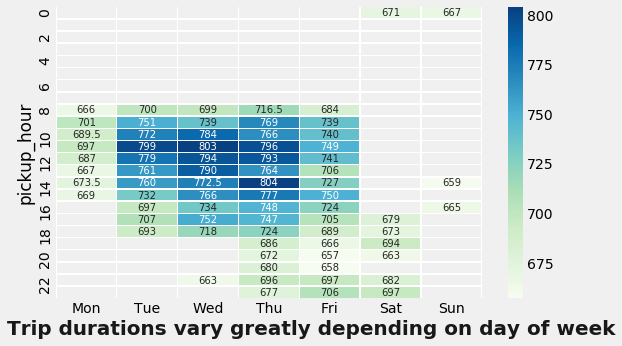

In [19]:
# Trips by Hour and Day of Week
trip_duration_median = train['trip_duration'].median()
plt.figure(figsize=(8.5,5))

pickup_hourday = train.groupby(['pickup_hour','pickup_weekday'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median], lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )


# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])


# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# # Adding a title and a subtitle
hourday_graph.text(x =-.8, y = 27, s = "Trip durations vary greatly depending on day of week",
               fontsize =20 , weight = 'bold', alpha = .90)

plt.show()

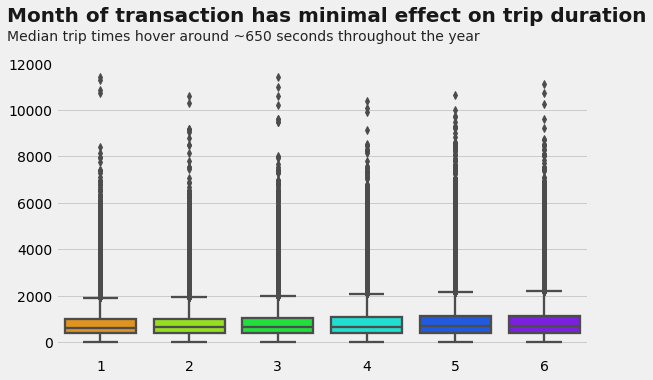

In [20]:
# Box plot of pickups by month
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
month_graph = sns.boxplot(x = 'pickup_month', y = 'trip_duration', data = train, palette = 'gist_rainbow', linewidth = 2.3)

# Remove the label of the x-axis
month_graph.xaxis.label.set_visible(False)
month_graph.yaxis.label.set_visible(False)

month_graph.text(x =-1.05, y = 13800, s = "Month of transaction has minimal effect on trip duration",
               fontsize =20 , weight = 'bold', alpha = .90)
month_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times hover around ~650 seconds throughout the year',
              fontsize = 14, alpha = .85)
plt.show()

### 4. FEATURES ENGINEERING

In [21]:
# Encoding Categoric data (converting 'store_and_fwd_flag' to numeric)
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N':0,'Y':1})

In [22]:
train.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday', 'dist_long', 'dist_lat', 'dist'],
      dtype='object')

In [23]:
train.drop(columns=['pickup_date','pickup_time','dropoff_date', 'dropoff_time'], axis = 1, inplace = True)

## 4. MODELING

In [24]:
X = train[['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour',
       'pickup_weekday']]

In [25]:
y = train['trip_duration']

###    Train/valid spliting 

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.2, random_state = 0)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1149660, 10), (1149660,), (287416, 10), (287416,))

### Model  selection

In [28]:
lr = LinearRegression()

### Model training

In [29]:
# Fit to training data
lr.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Making Prediction

In [30]:
y_pred = lr.predict(X_val)
print(y_pred)

[826.29655541 532.96094989 896.15811564 ... 839.63010995 630.78138744
 755.77954219]


### Scoring the model

In [31]:
# Score using 

from sklearn import metrics
print('\nLinear Regression Performance Metrics')
print('R^2=',metrics.explained_variance_score(y_val,y_pred))
print('MAE:',metrics.mean_absolute_error(y_val,y_pred))
print('MSE:',metrics.mean_squared_error(y_val,y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_val,y_pred)))


Linear Regression Performance Metrics
R^2= 0.23280782243342857
MAE: 406.4232963534118
MSE: 320045.00709366665
RMSE: 565.7252045769807


In [32]:
lasso = linear_model.Lasso()
cvs = cross_val_score(lasso, X, y, cv=20)
print(cvs)

[0.21724806 0.22439289 0.22606327 0.22251941 0.22036198 0.21706228
 0.22789603 0.22299006 0.21794316 0.22873346 0.22471899 0.22200648
 0.22676283 0.22515456 0.21964548 0.22753072 0.22538305 0.22706017
 0.22847525 0.22335491]


In [33]:
np.mean(cvs)

0.22376515215078455

In [34]:
#predicted = cross_val_predict(lr, train, y, cv=10)

##  6. SUBMISSION

### Test feature settings 

In [35]:
# Convert timestamps to date objects
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime) # Pickups

# Delimit pickup_datetime variable 
test['pickup_date'] = test['pickup_datetime'].dt.date # Extract date
test['pickup_time'] = test['pickup_datetime'].dt.time # Extract time

# Additional pickup features
test['pickup_month'] = test['pickup_datetime'].dt.month # Extract month

#train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
test['pickup_hour'] = test['pickup_datetime'].dt.hour # Extract hour
test['pickup_weekday'] = test['pickup_datetime'].dt.dayofweek # Extract day of week

# Encode categorical variables
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].map({'N':0,'Y':1})

In [36]:
# Create new matrix of features from test data    
X_test= test[['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_month', 'pickup_hour',
       'pickup_weekday']]

In [37]:
test_pred = lr.predict(X_test)

In [38]:
test.head(1)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dist_long,dist_lat,dist,pickup_date,pickup_time,pickup_month,pickup_hour,pickup_weekday
0,id3004672,1,2016-06-30 23:59:58,1,-73.988,40.732,-73.990,40.757,0,0.002,-0.025,0.025,2016-06-30,23:59:58,6,23,3


In [39]:
submission = pd.DataFrame({'id':test['id'], 'trip_duration': test_pred})
submission.to_csv('mySubmission.csv')
